# <font color='lightblue'>Computer Vision</font>

En este notebook veremos como implementar una arquitectura de red para procesar imágenes y que aprenda a obtener patrones (pixeles) que le sirvan para hacer una clasificación.

Usaremos el dataset [Food101](https://www.kaggle.com/datasets/dansbecker/food-101) para distintas tareas. Espero que no les de hambre xd.

Veremos:
1. Clasificación binaria (sigmoid).
2. Clasificación multi-clase (softmax/argmax).
3. Transfer Learning.

## 1. Clasificación binaria de imágenes

Primero cargamos el dataset que contiene solo imágenes de pizzas y steaks(carne) para entrenar una red neuronal convolucional para clasificación binaria.



### Cargamos el dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2023-10-02 22:47:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c03::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   145MB/s    in 0.7s    

2023-10-02 22:47:14 (145 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [ ]:
!nvidia-smi

Mon Oct  2 22:47:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Extraemos del archivo zip las carpetas
import zipfile
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

>**Nota:** La estructura de carpetas bajo el nombre de train o test y luego bajo el nombre de pizza o steak en cada caso, es el tipo de estructura que necesita `TensorFlow` para saber cual es la carpeta de entrenamiento y testeo, y cual es la clase (etiqueta) de cada grupo de imagen. Con esta clase que encuentra en el nombre de la carpeta es la que va a utilizar para entrenarse.

In [ ]:
import os
os.listdir('pizza_steak/train/')

['steak', 'pizza']

In [ ]:
# Exploramos las carpetas un poco...
import os

for dir, dirname, files in os.walk('pizza_steak'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: pizza_steak | subdir: ['train', 'test'] | cant de imagenes: 0 
Dir: pizza_steak/train | subdir: ['steak', 'pizza'] | cant de imagenes: 0 
Dir: pizza_steak/train/steak | subdir: [] | cant de imagenes: 750 
Dir: pizza_steak/train/pizza | subdir: [] | cant de imagenes: 750 
Dir: pizza_steak/test | subdir: ['steak', 'pizza'] | cant de imagenes: 0 
Dir: pizza_steak/test/steak | subdir: [] | cant de imagenes: 250 
Dir: pizza_steak/test/pizza | subdir: [] | cant de imagenes: 250 


Vemos que la carpeta `train` contiene 750 imágenes de pizza y 750 de steak.

La carpeta `test` contiene 250 imágenes de pizza y 250 imágenes de steak.

In [ ]:
#Guardamos el nombre de las carpetas que haya dentro de train en una lista
# se puede hacer a mano pero a veces son muchas y podemos cometer errores.

classes = [f for f in os.listdir('pizza_steak/test/')]
print(classes)

['steak', 'pizza']


### Visualizamos algunos ejemplos del dataset

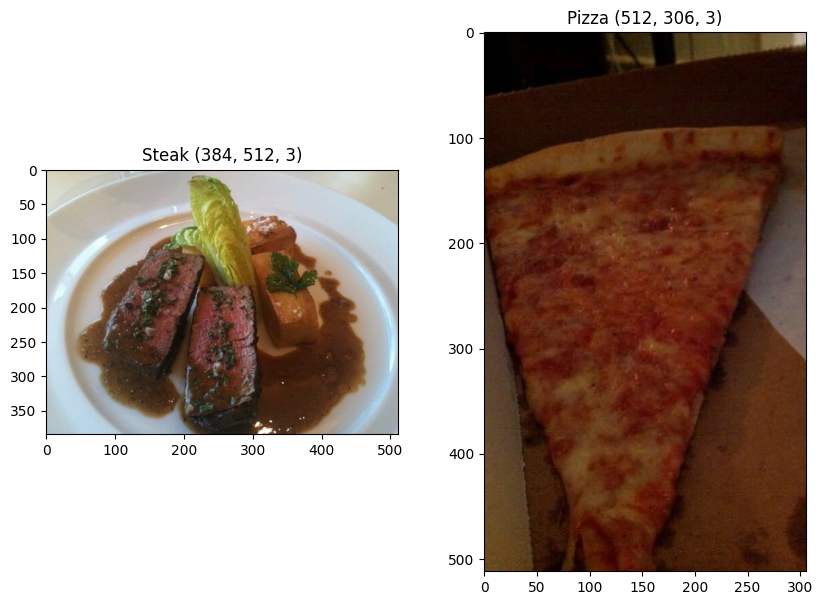

In [ ]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10,7))
id = random.choice(range(0,749))
plt.subplot(1,2,1)
img_name = [f for f in os.listdir('pizza_steak/train/steak/')][id]
img = plt.imread('pizza_steak/train/steak/'+img_name)
plt.imshow(img)
plt.title('Steak '+str(img.shape))
plt.subplot(1,2,2)
img_name = [f for f in os.listdir('pizza_steak/train/pizza/')][id]
img = plt.imread('pizza_steak/train/pizza/'+img_name)
plt.imshow(img)
plt.title('Pizza '+str(img.shape));

In [ ]:
#Exploramos los características de las imágenes
lista_img_pizza = [f for f in os.listdir('pizza_steak/train/pizza/')]
imagen_prueba = plt.imread('pizza_steak/train/pizza/'+lista_img_pizza[23]) #Elegimos la primera de las imágenes de la lista para leerlas
print(f"Shape de la imagen: {imagen_prueba.shape}")
print(f"Dimensiones de la imagen: {imagen_prueba.ndim}")
print(f"Codificación la imagen: {imagen_prueba.dtype}")
print(f"Pixel de mayor valor: {imagen_prueba.max()}")
print(f"Pixel de menor valor: {imagen_prueba.min()}")

Shape de la imagen: (512, 512, 3)
Dimensiones de la imagen: 3
Codificación la imagen: uint8
Pixel de mayor valor: 255
Pixel de menor valor: 0


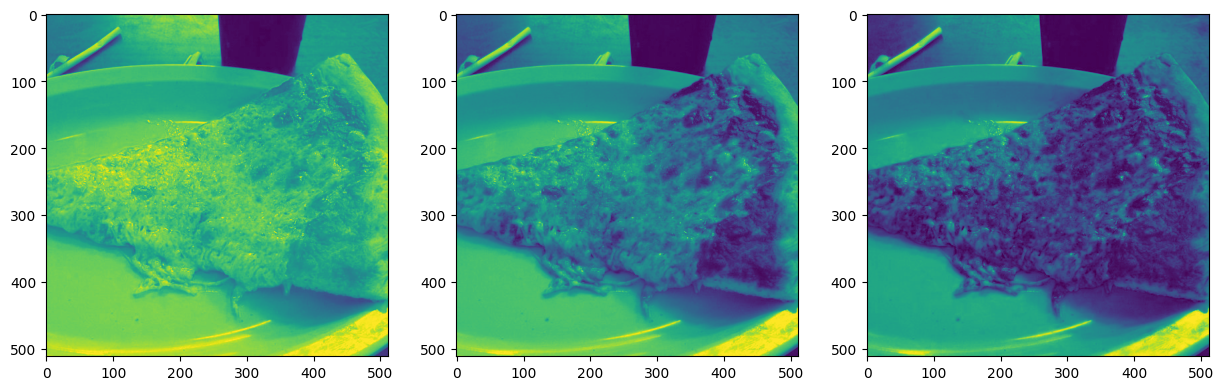

In [ ]:
imagen_prueba = plt.imread('pizza_steak/train/pizza/'+lista_img_pizza[22])
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(imagen_prueba[:,:,0],cmap=None)
plt.subplot(1,3,2)
plt.imshow(imagen_prueba[:,:,1],cmap=None)
plt.subplot(1,3,3)
plt.imshow(imagen_prueba[:,:,2],cmap=None)

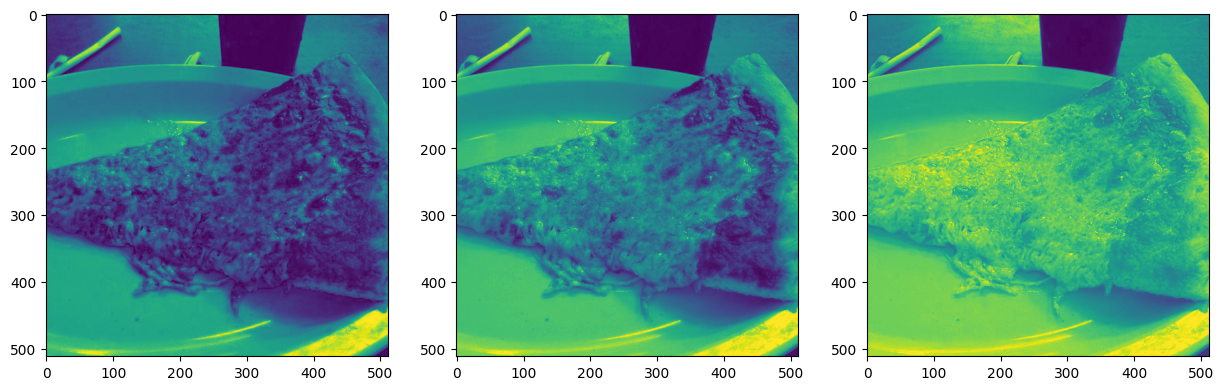

In [ ]:
import cv2
imagen_prueba = cv2.imread('pizza_steak/train/pizza/'+lista_img_pizza[22])
b,g,r =  cv2.split(imagen_prueba)
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(b,cmap=None)
plt.subplot(1,3,2)
plt.imshow(g,cmap=None)
plt.subplot(1,3,3)
plt.imshow(r,cmap=None);

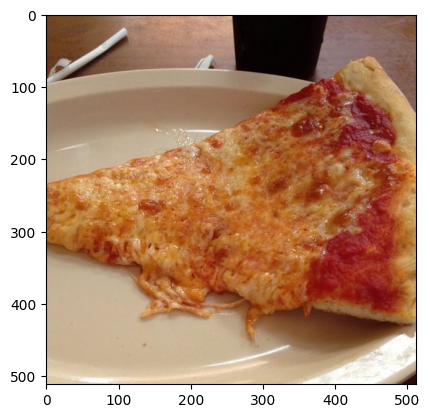

In [ ]:
imagen_reconstruida = cv2.merge([r,g,b])
plt.imshow(imagen_reconstruida);

### Creamos la arquitectura de una red neuronal convolucional
Vamos a construir una red neuronal convolucional para encontrar patrones en nuestras imágenes, más específicamente, necesitamos una forma de:
* Cargar la imágenes con TensorFlow
* Preprocesar las imágenes para escalarlas.
* Construir la red convolucional para clasificación
* Compilar la CNN
* Entrenar la CNN con los datos de entrenamiento.

In [ ]:
# Primero instanciamos el generador de dataset
# Este lo que hace es permitirnos preprocesar las imagenes (rescalarlas y aplicarles tecnicas de data augmentation)
import tensorflow as tf
tf.random.set_seed(42) #usamos este seed para que cada vez que ejecutemos la celda nos repetira los mismos valores, se usa mucho cuando queremos replicar experimentos

train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,#Data augmentation
                                                                  vertical_flip=True)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='binary') #multiclass -> 'categorical' [001,100,010]

test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='binary')


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
imagenes, etiquetas = train_batch[0]
print(len(imagenes),len(etiquetas))

32 32


In [ ]:
etiquetas

array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
      dtype=float32)

In [ ]:
import tensorflow as tf
#Creamos la red convolucional

model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=((224,224,3))),
    tf.keras.layers.Flatten(),# vectorizacion de las imágenes
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 256)               38535424  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 38634241 (147.38 MB)
Trainable params: 38634241 (147.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Observamos que la cantidad de parámetros en una red fully connected, con solo capas profundas para entrenar con imágenes, resulta muy grande. Y con esto crece la necesidad de poder de computo a la vez que la red tiene que aprender pixel a pixel, lo cual lleva mucho más tiempo.

Una solución a esto es incorporar capas de filtrado, que filtren solo aquella información de la imagen que la red "crea" que es importante. Con esto la cantidad de parámetros se reduce a solo los parametros de dichos filtros, que resultan en menor cantidad y tiempo de procesamiento.

In [ ]:
#Creamos la red convolucional

model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'), #Conv -> Maxpooling -> Conv -> Maxpooling -> Flatten(vectorización) -> DNN
    tf.keras.layers.MaxPool2D(strides=(1, 1)),
    tf.keras.layers.Conv2D(5, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(1, 1)),
    tf.keras.layers.Dropout((0.20)),
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),#se vectoriza
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 5)       140       
                                                                 
 max_pooling2d (MaxPooling2  (None, 221, 221, 5)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 219, 219, 5)       230       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 218, 218, 5)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 218, 218, 5)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 216, 216, 5)      

In [ ]:
## Compilamos el modelo
model_0.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
## Entrenamos el modelo
model_0.fit(train_batch,
            epochs=5000000,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/model_0',save_best_only=True),
                         tf.keras.callbacks.TensorBoard('logs/model_0'),
                         tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/5000000
47/47 [==============================] - 22s 201ms/step - loss: 0.6977 - accuracy: 0.5207 - precision: 0.5250 - recall: 0.4333 - val_loss: 0.6778 - val_accuracy: 0.5600 - val_precision: 0.7885 - val_recall: 0.1640
Epoch 2/5000000
47/47 [==============================] - 10s 214ms/step - loss: 0.6406 - accuracy: 0.6473 - precision: 0.6499 - recall: 0.6387 - val_loss: 0.5883 - val_accuracy: 0.7240 - val_precision: 0.7059 - val_recall: 0.7680
Epoch 3/5000000
47/47 [==============================] - 6s 126ms/step - loss: 0.5782 - accuracy: 0.7147 - precision: 0.7307 - recall: 0.6800 - val_loss: 0.5975 - val_accuracy: 0.6860 - val_precision: 0.6247 - val_recall: 0.9320
Epoch 4/5000000
47/47 [==============================] - 9s 189ms/step - loss: 0.5462 - accuracy: 0.7320 - precision: 0.7417 - recall: 0.7120 - val_loss: 0.5313 - val_accuracy: 0.7440 - val_precision: 0.7243 - val_recall: 0.7880
Epoch 5/5000000
47/47 [==============================] - 8s 171ms/step - loss: 0.5

### Evaluamos el modelo

Para esto vamos a importarlo de la carpeta donde se guardaron los checkpoints.

In [ ]:
model_0 = tf.keras.models.load_model('/content/checkpoints/model_0')

In [ ]:
model_0.evaluate(test_batch)

16/16 [==============================] - 2s 83ms/step - loss: 0.5202 - accuracy: 0.7600 - precision: 0.7044 - recall: 0.8960


[0.5201520919799805, 0.7599999904632568, 0.704402506351471, 0.8960000276565552]

In [ ]:
# Podemos ver las métricas con TensorBoard que guardamos durante el entrenamiento
!tensorboard dev upload --logdir=logs/model_0  #tensorboard --logdir=

2023-10-02 23:31:55.895833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs/model_0

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   KHJB-VZPF

KHJB-VZPF

Upload started and will continue reading any new data as it's added to the

### Hacemos una predicción

In [ ]:
# Elegimos una imagen de dataset a gusto
img = plt.imread('/content/pizza_steak/test/pizza/1180273.jpg')

#Rescalamos la imagen para introducirla al modelo
img = img/255.
# Tensorflow usa float16 / float32

#Ajustamos la imagen a 224,224,3

img.resize((224,224,3))
img_expanded = tf.expand_dims(img, axis=0) # TensorFlow (None, 224, 224 ,3) np.expand_dims(img,axis=0)

y_pred = model_0.predict(img_expanded)
print(y_pred)

1/1 [==============================] - 0s 52ms/step
[[0.99891496]]


In [ ]:
# A la salida del modelo le quitamos la dimensión extra que tiene y redondeamos el valor a la clase más cercana (en este caso 0)
y_pred = tf.squeeze(y_pred) # Eliminar dimensiones vacias [[0.005]] -> [0.005]
y_pred = tf.round(y_pred)
print(f"La predicción para la imagen de pizza es: {y_pred} ")

La predicción para la imagen de pizza es: 1.0 


# Ejercicio 1

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. La cantidad de filtros de las capas convolucionales pueden ir creciendo (16, 32,64)
2. El tamaño del kernel de los filtros también puede crecer 7x7, 9x7, 11x11.
3. Podemos implementar data augmentation.
4. Podemos usar dropout en la red profunda.
5. Podemos cambiar el learning rate.

In [ ]:
#Insertar ejercicio aquí...



---



## 2. Clasificación multiclase de imágenes

Para este ejercicio tomaremos 10 comidas del mismo dataset original.

Lo importamos en formato zip, por lo que despues lo descomprimimos usando `zipfile`.

Para este ejercicio deberán seguir los siguientes pasos:
1. Convertirse uno con los datos. Es decir, exploren a fondo el dataset para tener un entendimiento total.
2. Preprocesar los datos.
3. Crear un modelo.
4. Compilar el modelo
5. Entrenar el modelo.
6. Evaluar el modelo.
7. Ajustar diferentes hiperparámetros y mejorar el modelo (intentar superar las metricas que ya se tienen y reducir el sobreajuste).
8. Repetir los pasos hasta que las metricas sean las deseadas.

### Cargamos el dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-10-02 23:47:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   106MB/s    in 5.6s    

2023-10-02 23:47:50 (87.7 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
## Extraemos del archivo zip las carpetas
import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Exploramos las carpetas...
import os
for dir, dirname, files in os.walk('10_food_classes_all_data'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: 10_food_classes_all_data | subdir: ['train', 'test'] | cant de imagenes: 0 
Dir: 10_food_classes_all_data/train | subdir: ['steak', 'pizza', 'hamburger', 'grilled_salmon', 'ice_cream', 'chicken_curry', 'ramen', 'sushi', 'fried_rice', 'chicken_wings'] | cant de imagenes: 0 
Dir: 10_food_classes_all_data/train/steak | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/pizza | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/hamburger | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/grilled_salmon | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/ice_cream | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/chicken_curry | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/ramen | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/sushi | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/fried_rice | subdir:

Vemos que la carpeta `train` contiene 750 imágenes de cada clase: ['sushi', 'chicken_wings', 'chicken_curry', 'pizza', 'hamburger', 'grilled_salmon', 'fried_rice', 'steak', 'ice_cream', 'ramen']

La carpeta `test` contiene 250 imágenes de cada clase: ['sushi', 'chicken_wings', 'chicken_curry', 'pizza', 'hamburger', 'grilled_salmon', 'fried_rice', 'steak', 'ice_cream', 'ramen']

In [ ]:
classes = [f for f in os.listdir('10_food_classes_all_data/test')]
print(classes)

['steak', 'pizza', 'hamburger', 'grilled_salmon', 'ice_cream', 'chicken_curry', 'ramen', 'sushi', 'fried_rice', 'chicken_wings']


### Visualizamos algunos ejemplos del dataset

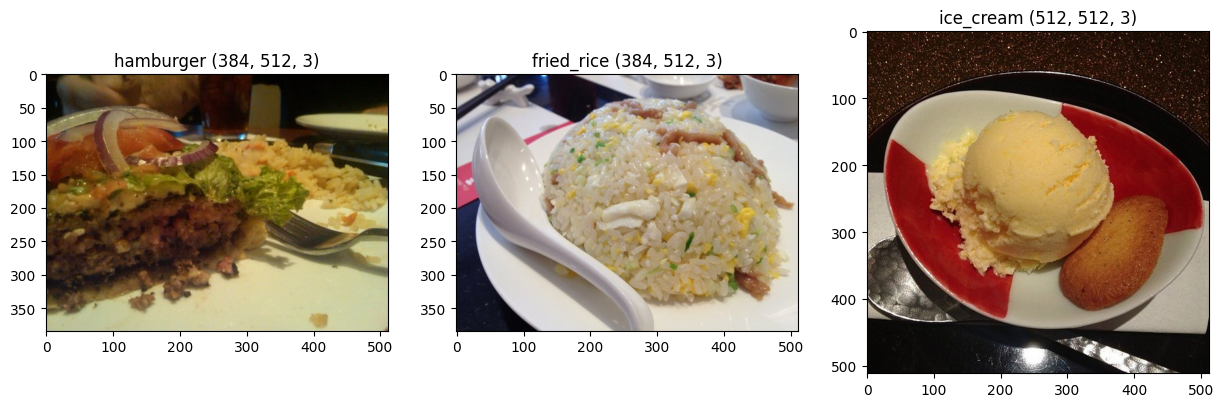

In [ ]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(15,7))
id = random.choice(range(0,749))
plt.subplot(1,3,1)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/hamburger')][id]
img = plt.imread('10_food_classes_all_data/train/hamburger/'+img_name)
plt.imshow(img)
plt.title('hamburger '+str(img.shape))
plt.subplot(1,3,2)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/fried_rice/')][id]
img = plt.imread('10_food_classes_all_data/train/fried_rice/'+img_name)
plt.imshow(img)
plt.title('fried_rice '+str(img.shape))
plt.subplot(1,3,3)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/ice_cream/')][id]
img = plt.imread('10_food_classes_all_data/train/ice_cream/'+img_name)
plt.imshow(img)
plt.title('ice_cream '+str(img.shape));

In [ ]:
#Exploramos los características de las imágenes
lista_img_pizza = [f for f in os.listdir('10_food_classes_all_data/train/hamburger/')]
imagen_prueba = plt.imread('10_food_classes_all_data/train/hamburger/'+random.choice(lista_img_pizza)) #Elegimos la primera de las imágenes de la lista para leerlas
print(f"Shape de la imagen: {imagen_prueba.shape}")
print(f"Dimensiones de la imagen: {imagen_prueba.ndim}")
print(f"Codificación la imagen: {imagen_prueba.dtype}")
print(f"Pixel de mayor valor: {imagen_prueba.max()}")
print(f"Pixel de menor valor: {imagen_prueba.min()}")

Shape de la imagen: (382, 512, 3)
Dimensiones de la imagen: 3
Codificación la imagen: uint8
Pixel de mayor valor: 255
Pixel de menor valor: 0


### Creamos la arquitectura CNN para multi-clasificación

In [ ]:
import tensorflow as tf
print(f"Version: {tf.__version__}")

Version: 2.13.0


In [ ]:
tf.random.set_seed(42)

train_dir = '/content/10_food_classes_all_data/train/'
test_dir = '/content/10_food_classes_all_data/test/'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical') #Usamos categorical para referirnos a que son más de dos clases
test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical') #'sparse'

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
images, etiquetas = train_batch[0]
etiquetas [:5] #ONE HOT ENCODER

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
#Creamos la red convolucional

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 flatten_2 (Flatten)         (None, 27040)            

In [ ]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

In [ ]:
model_1.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10),
                         tf.keras.callbacks.ReduceLROnPlateau(patience=5)]) #Converger al minimo

Epoch 1/200
235/235 [==============================] - 33s 126ms/step - loss: 2.1324 - accuracy: 0.2236 - val_loss: 1.9995 - val_accuracy: 0.2748 - lr: 0.0010
Epoch 2/200
235/235 [==============================] - 29s 123ms/step - loss: 1.8828 - accuracy: 0.3368 - val_loss: 1.8545 - val_accuracy: 0.3432 - lr: 0.0010
Epoch 3/200
157/235 [===================>..........] - ETA: 8s - loss: 1.7388 - accuracy: 0.4051

KeyboardInterrupt: ignored

### Evaluamos el modelo

In [ ]:
model_1.evaluate(test_batch)

### Hacemos una predicción

In [ ]:
# Elegimos una imagen de dataset a gusto
img = plt.imread('/content/10_food_classes_all_data/test/fried_rice/1023430.jpg')

#Rescalamos la imagen para introducirla al modelo
img = img/255.

#Ajustamos la imagen a 224,224,3

img.resize((224,224,3))
img_expanded = tf.expand_dims(img, axis=0)

y_pred = model_1.predict(img_expanded)
print(y_pred) #Softmax

In [ ]:
y_pred = tf.squeeze(y_pred)
tf.math.reduce_sum(y_pred).numpy()

In [ ]:
tf.argmax(y_pred).numpy()

In [ ]:
y_pred = tf.squeeze(y_pred)
y_pred = tf.round(y_pred)
print(f"La predicción para la imagen de pizza es: {y_pred} ") #ARGMAX

In [ ]:
y_pred = tf.argmax(y_pred) #argmax retorna el indice del item mayor de todos los items
print(f"La clase es: {classes[y_pred]}")

# Ejercicio 2

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. La cantidad de filtros de las capas convolucionales pueden ir creciendo (16, 32,...)
2. El tamaño del kernel de los filtros también puede crecer.
3. Podemos implementar data augmentation (más tecnicas).
4. Podemos usar dropout en la red profunda.
5. Podemos cambiar el learning rate.

In [ ]:
# Insertar codigo aquí...



---



## 3. Transfer Learning

O también conocido cómo `fine tuning` es el método por el cual instanciamos una red neuronal convolucional previamente entrenada para otra tarea, pero sus filtros de más bajo nivel sirven para muchos propositos.

Nosotros tomamos esa CNN y re-entrenamos sus capas de más alto nivel para el objetivo que queremos lograr (por ejemplo clasificar comida en imágenes).

Para esto `keras` ya tiene implementado varios arquitecturas pre-entrenadas, las más conocidas son:

* AlexNet
* VGG 16
* VGG 19
* Inception
* ResNet
* EfficientNet


In [ ]:
base_model = tf.keras.applications.VGG19(include_top=False, #sin la parte dnn
                                         weights='imagenet') #EfficienteNetB0
base_model.trainable = False

In [ ]:
for layer_num, layers in enumerate(base_model.layers):
  print(layer_num, layers)

0 <keras.src.engine.input_layer.InputLayer object at 0x78d2c6dba890>
1 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78d2a93e23b0>
2 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78d31dc73100>
3 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78d222ea4d90>
4 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78d2a151aad0>
5 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78d222ee6920>
6 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78d2a0443460>
7 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78d222e7da20>
8 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78d2a93e19c0>
9 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78d222ea7af0>
10 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78d2a04421d0>
11 <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78d2a0440550>
12 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78d2a0441210>
13 <keras.src.layer

In [ ]:
#Creamos la red convolucional

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    base_model, #vgg19
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               6422784   
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                                 
Total params: 26449738 (100.90 MB)
Trainable params: 6425354 (24.51 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
model_2.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
model_2.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/200
235/235 [==============================] - 65s 261ms/step - loss: 1.8465 - accuracy: 0.4641 - val_loss: 1.2777 - val_accuracy: 0.5612
Epoch 2/200
235/235 [==============================] - 56s 236ms/step - loss: 1.0836 - accuracy: 0.6423 - val_loss: 1.0678 - val_accuracy: 0.6400
Epoch 3/200
235/235 [==============================] - 60s 257ms/step - loss: 0.8598 - accuracy: 0.7177 - val_loss: 1.1689 - val_accuracy: 0.6228
Epoch 4/200
235/235 [==============================] - 57s 243ms/step - loss: 0.7176 - accuracy: 0.7656 - val_loss: 1.1293 - val_accuracy: 0.6260
Epoch 5/200
235/235 [==============================] - 55s 234ms/step - loss: 0.5884 - accuracy: 0.8111 - val_loss: 1.0705 - val_accuracy: 0.6444
Epoch 6/200
235/235 [==============================] - 53s 227ms/step - loss: 0.5039 - accuracy: 0.8323 - val_loss: 1.1173 - val_accuracy: 0.6548
Epoch 7/200
235/235 [==============================] - 52s 220ms/step - loss: 0.4094 - accuracy: 0.8672 - val_loss: 1.1750 -

In [ ]:
model_2.evaluate(test_batch)

>**Nota:** Vemos que la implementación de la tecnica de `Transfer Learning` con un modelo pre-entrenado mejoro sustancialmente los valores de las métricas de evaluación.

# Ejercicio 3

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. Probar otras redes pre entrenadas convolucionales: ['ResNet101','EfficientNetB0','InceptionNet']

[Link](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [ ]:
#Insertar ejercicio aquí...